# Experiments on the TownCentre dataset

This is the reproduction of the experiments described and shown in Section 4.3 of the BiternionNets paper, including the results shown in Table 3, as well as Table 4 in Secton 5.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pickle, gzip
from collections import Counter

In [2]:
%matplotlib inline

# Font which got unicode math stuff.
import matplotlib as mpl
mpl.rcParams['font.family'] = 'DejaVu Sans'

# Much more readable plots
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
import DeepFried2 as df

In [4]:
import tensorflow as tf
import tensorflow.contrib.slim as slim

In [5]:
from lbtoolbox.thutil import count_params
from lbtoolbox.augmentation import AugmentationPipeline, Cropper

Functions for training and evaluating that are shared across notebooks.

In [6]:
from training_utils import dotrain, dostats, dopred

# Utilities and plotting

These functions can be used for "cyclic" filtering of a 1D array, such as a histogram of angles as will be used later.

In [7]:
def boxfilter(n):
    return np.ones(n)/n

def gaussfilter(n, sigma=0.3, retx=False, norm=np.sum):
    x = np.arange(-(n-1)/2, (n+1)/2)
    x /= np.max(x)
    y = 1/(sigma * np.sqrt(2*np.pi)) * np.exp(-x**2/(2*sigma**2))
    if norm is not None:
        y /= norm(y)
    return (x, y) if retx else y

def cyclic_filter(a, f):
    # Pad in a cyclic way so that we can use 'same' convolution to cycle.
    a = np.pad(a, pad_width=len(f)//2, mode='wrap')
    # While it doesn't make a difference here because `f` is symmetric,
    # we use `correlate` because `convolve` flips the filter.
    return np.correlate(a, f, mode='valid')

The following function generates kind-of a histogram over the cyclic range [0,360] using an array of predictions `preds`.

In [8]:
def mkheatmap_deg(preds, nbins=360):
    """
    - `preds`: The array of angle predictions.
    - `norm`: function of the count-values by the return value of which to divide. Examples:
        - `sum` for getting a "frequency" histogram (if without filtering).
        - `max` for getting a histogram whose peak is at 1 (if without filtering).
        - `None` for an unnormalized "counts" histogram.
    - `nbins`: Obvious.
    """
    # Make sure to be in [0,360) range for Counter.
    preds = (preds + 3600) % 360
    hm = np.zeros(nbins)

    # Discretize the predictions into the bins we have.
    ipreds = (preds/(360/nbins)).astype(int)

    counter = Counter(ipreds)

    # Fill heatmap.
    for a, n in counter.items():
        hm[a] += n

    return hm

Here's an example of how to use this, together with filtering/smoothing:

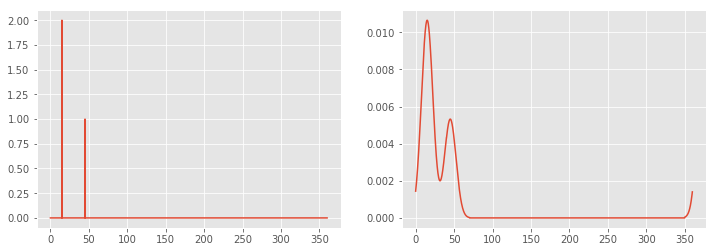

In [9]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
hm = mkheatmap_deg(np.array([15, 15, 45.]), nbins=3600)
axes[0].plot(np.linspace(0, 360, len(hm)), hm);
hm = cyclic_filter(hm, gaussfilter(n=501))
axes[1].plot(np.linspace(0, 360, len(hm)), hm);

The following creates a "donut heatmap" which is the donut-shaped histogram introduced in the paper.

In [10]:
def donut_heatmap(hm, bg, R, zero_rad=np.deg2rad(-90), colormap=mpl.cm.Spectral_r, aapow=None):
    """
    - `hm`: The heatmap distribution as returned by `donut_heatmap`.
    - `bg`: Either a tuple specifying the size of the image: `(h, w, depth)`.
            Or an image (as a (h,w,d) numpy array) on top of which to draw the heatmap.
    - `R`: the width, in pixels, of the donut.
    - `zero_rad`: The angle at which to place zero, relative to mathematical zero (on the right).
    - `colormap`: Obviously, which colormap to use.
    - `aapow`: A fiddling parameter for the fake anti-aliasing effect. The higher the sharper, or `None` for no aa.
    """

    if isinstance(bg, tuple):
        if len(bg) == 2:
            bg += (4,)
        bg = np.zeros(bg)
    else:
        bg = np.copy(bg)

    assert len(bg.shape) == 3 and bg.shape[-1] in (3,4), "Can only put a donut onto a color image!"

    h, w = bg.shape[:2]
    assert w == h, "Currently, we only work for squares, because no time to test ellipses!"

    # First, take the distribution as-is and draw it into a donut.
    cx, cy = w/2, h/2
    for y in range(h):
        for x in range(w):
            l = np.hypot((x-cx), (y-cy))
            lc = (l - (w/2-R/2))/(R/2)  # Center it at the center of the donut band and put into [-1,1].
            if -1 < lc < 1:
                angle = (np.rad2deg(np.arctan2(-(y-cy), x-cx) - zero_rad) + 360) % 360
                bg[y,x] = colormap(hm[int(angle*len(hm)/360)])
                if aapow is not None:
                    bg[y,x,3] = 1 - (np.exp(lc**aapow)-1)/(np.exp(1)-1)

    return bg

And this combines these functions in order to compute and draw a beautiful donut from given predictions.

In [11]:
def donut(ax, hm, **kw):
    im = ax.imshow(donut_heatmap(hm, **kw))
    ax.grid(False)
    ax.axis('off')
    ax.patch.set_visible(False)
    return im

def donut_default(ax, angles, **kw):
    return donut(ax, cyclic_filter(mkheatmap_deg(angles, nbins=3600), gaussfilter(41)), **kw)

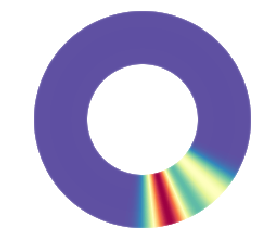

In [12]:
fig, ax = plt.subplots(figsize=(4,4))
donut(ax, hm/np.max(hm), bg=(201,201), R=50, aapow=40);

# Load TownCentre Data

In [13]:
X, y, n = pickle.load(gzip.open('data/TownCentre.pkl.gz', 'rb'))

Now, we need to split the dataset into train/test sets. But we need to be careful in doing the splitting since we don't want the exact same person to be present in both sets, that would make the task extremely easy and close to cheating.

Unfortunately, I didn't save the split which I used for the paper and hence there's no "official" split. Sorry for that, it's actually a big fuckup of mine. For this reason, the numbers in here can be quite different than the ones from the paper, although the relative improvements of various methods do stay the same.

In [14]:
def split(X, y, n, split=0.9):
    itr, ite, trs, tes = [], [], set(), set()
    for i, name in enumerate(n):
        # Extract the person's ID.
        pid = int(name.split('_')[1])

        # Decide where to put that person.
        if pid in trs:
            itr.append(i)
        elif pid in tes:
            ite.append(i)
        else:
            if np.random.rand() < split:
                itr.append(i)
                trs.add(pid)
            else:
                ite.append(i)
                tes.add(pid)
    return (X[itr], y[itr], [n[i] for i in itr]), (X[ite], y[ite], [n[i] for i in ite])

In [15]:
(Xtr, ytr, ntr), (Xte, yte, nte) = split(X, y, n, split=0.9)
Xtr, ytr = Xtr.astype(df.floatX)/255, ytr.astype(df.floatX)
Xte, yte = Xte.astype(df.floatX)/255, yte.astype(df.floatX)
print("Trainset: {}".format(len(Xtr)))
print("Testset:  {}".format(len(Xte)))

Trainset: 7746
Testset:  948


Some examples of usage. Tune the various parameters in order for the heatmap to look good in your case. Note that the `norm` here is just a rescaling influencing which range of the heatmap is used. The size of the `filt` should not be too large or it will wash-out the actual distribution, which could be seen as cheating!

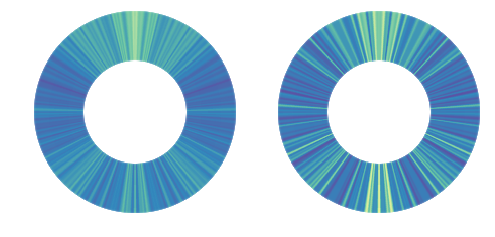

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
hm_ytr = cyclic_filter(mkheatmap_deg(ytr, nbins=3600), gaussfilter(41))
hm_yte = cyclic_filter(mkheatmap_deg(yte, nbins=3600), gaussfilter(41))
donut(axes[0], hm_ytr/(len(ytr)/400), bg=(201, 201), R=50, aapow=40);
donut(axes[1], hm_yte/(len(yte)/400), bg=(201, 201), R=50, aapow=40);

Here are the "raw", i.e. not re-scaled heatmaps just for reference. Notice the colors are exactly the same as above, but uglier because of higher frequency.

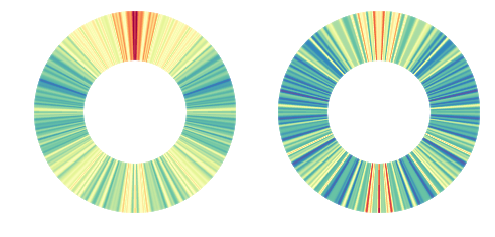

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
hm_ytr = cyclic_filter(mkheatmap_deg(ytr, nbins=3600), gaussfilter(41))
hm_yte = cyclic_filter(mkheatmap_deg(yte, nbins=3600), gaussfilter(41))
donut(axes[0], hm_ytr/np.max(hm_ytr), bg=(201, 201), R=50, aapow=40);
donut(axes[1], hm_yte/np.max(hm_yte), bg=(201, 201), R=50, aapow=40);

# Network creation and evaluation functions

In [18]:
aug = AugmentationPipeline(Xtr, ytr, Cropper((46,46)))

In [19]:
class Flatten(df.Module):
    def symb_forward(self, symb_in):
        return symb_in.flatten(2)

In [20]:
def mknet(*outlayers):
    return df.Sequential(                          #     3@46
        df.SpatialConvolutionCUDNN( 3, 24, 3, 3),  # -> 24@44
        df.BatchNormalization(24),
        df.ReLU(),
        df.SpatialConvolutionCUDNN(24, 24, 3, 3),  # -> 24@42
        df.BatchNormalization(24),
        df.SpatialMaxPoolingCUDNN(2, 2),           # -> 24@21
        df.ReLU(),
        df.SpatialConvolutionCUDNN(24, 48, 3, 3),  # -> 48@19
        df.BatchNormalization(48),
        df.ReLU(),
        df.SpatialConvolutionCUDNN(48, 48, 3, 3),  # -> 48@17
        df.BatchNormalization(48),
        df.SpatialMaxPooling(2, 2),                # -> 48@9
        df.ReLU(),
        df.SpatialConvolutionCUDNN(48, 64, 3, 3),  # -> 48@7
        df.BatchNormalization(64),
        df.ReLU(),
        df.SpatialConvolutionCUDNN(64, 64, 3, 3),  # -> 48@5
        df.BatchNormalization(64),
        df.ReLU(),
        df.Dropout(0.2),
        Flatten(),
        df.Linear(64*5*5, 512),
        df.ReLU(),
        df.Dropout(0.5),
        *outlayers
    )

#### tensorflow additional functions

In [21]:
from lbtoolbox.util import batched

def mad_loss(y_target, y_pred):
    loss = tf.abs(y_target - y_pred)
    return loss

def input_tensors():
    x = tf.placeholder(tf.float32, shape=[None, 3, 46, 46])
    y_target = tf.placeholder(tf.float32, shape=[None, 1])
    return x, y_target

def adadelta_optimizer(loss):
    opt = tf.train.AdadeltaOptimizer(rho=0.95, learning_rate=1.0, epsilon=1e-7).minimize(loss)
    return opt

def dotrain_eval_tf(Xtr, ytr, Xte, yte, nruns = 5, nepochs=50, batchsize=100, debug_print=False):
    y_preds = []
    Xte_aug, yte_aug = aug.augbatch_train(Xte, yte)
    yte_aug = yte_aug[:,None]
    runs_epochs_losses = []
    for run_id in range(0, nruns):
        with tf.Session() as sess:
            sess.run(init_op)
            epochs_losses = []
            for epoch_id in range(0, nepochs):
                epoch_losses = []
                for Xb, yb in batched(batchsize, Xtr, ytr, shuf=True):
                    Xb_aug, yb_aug = aug.augbatch_train(Xb, yb)
                    yb_aug = yb_aug.reshape(-1,1)
                    _, preds, batch_losses = sess.run([train_step, y_pred_tf, loss_tf], 
                                                      feed_dict={x_tf: Xb_aug, y_target_tf: yb_aug.reshape(-1,1)})
                    epoch_losses.append(np.mean(batch_losses))
                mean_epoch_loss = np.mean(epoch_losses)
                epochs_losses.append(mean_epoch_loss)
                if debug_print:
                    print("epoch %d finished. mean epoch loss: %f" % (epoch_id, mean_epoch_loss))
            y_preds.append(sess.run(y_pred_tf, feed_dict={x_tf:Xte_aug}))
        runs_epochs_losses.append(epochs_losses)
        print("run %d finished" % run_id)
    return y_preds, runs_epochs_losses

#### error functions

In [22]:
def ensemble_degrees(angles):
    return np.arctan2(np.mean(np.sin(np.deg2rad(angles)), axis=0), np.mean(np.cos(np.deg2rad(angles)), axis=0))

In [23]:
def dopred_deg(model, aug, X, batchsize=100):
    return np.rad2deg(dopred(model, aug, X, ensembling=ensemble_degrees, output2preds=lambda x: x, batchsize=batchsize))

In [24]:
def maad_from_deg(preds, reals):
    return np.rad2deg(np.abs(np.arctan2(np.sin(np.deg2rad(reals-preds)), np.cos(np.deg2rad(reals-preds)))))

In [25]:
def show_errs_deg(preds, reals, epoch=-1):
    errs = maad_from_deg(preds, reals)
    mean_errs = np.mean(errs, axis=1)
    std_errs = np.std(errs, axis=1)
    print("Error: {:5.2f}°±{:5.2f}°".format(np.mean(mean_errs), np.mean(std_errs)))
    print("Stdev: {:5.2f}°±{:5.2f}°".format(np.std(mean_errs), np.std(std_errs)))

# Varying Output Layer and Criteria (Sec. 4.3)

## Pure Linear Regression

#### Theano + DeepFried

In [26]:
nets_shallow_linreg = [df.Sequential(
    Flatten(),
    df.Linear(3*46*46, 1, init=df.init.const(0)),
) for _ in range(5)]
#print('{:.3f}M params'.format(count_params(nets_shallow_linreg[0])/1000000))

#### TensorFlow

In [27]:
def weight_variable(shape):
    initial = tf.constant(0.01, shape=shape)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.01, shape=shape)
    return tf.Variable(initial)

def shallow_linear_regression_model(x):
    x_flat = tf.contrib.layers.flatten(x)
    W_fc = weight_variable([3*46*46, 1])
    b_fc = bias_variable([1])
    y = tf.matmul(x_flat, W_fc) + b_fc
    return y 

def dnn_model(x):
    x_flat = tf.contrib.layers.flatten(x)
    fc1 = slim.layers.fully_connected(x_flat, 512, activation_fn=tf.nn.relu)
    fc2 = slim.layers.fully_connected(fc1, 512, activation_fn=tf.nn.relu)
    fc3 = slim.layers.fully_connected(fc2, 512, activation_fn=tf.nn.relu)
    fc4 = slim.layers.fully_connected(fc3, 1, activation_fn=None)
    return fc4

### TF train procedure

#### Training for degrees

In [28]:
tf.reset_default_graph()

x_tf, y_target_tf = input_tensors()
y_pred_tf = shallow_linear_regression_model(x_tf)
loss_tf = mad_loss(y_target_tf, y_pred_tf)
train_step = adadelta_optimizer(loss_tf)

init_op = tf.global_variables_initializer()

nruns=5
y_preds_shallow_linreg, losses_plots = dotrain_eval_tf(Xtr, ytr, Xte, yte, debug_print=False, nruns=nruns)

run 0 finished
run 1 finished
run 2 finished
run 3 finished
run 4 finished


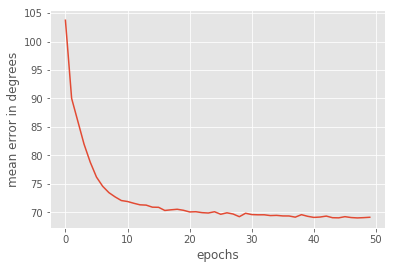

In [29]:
import matplotlib.pyplot as plt

plt.plot(range(0, len(losses_plots[0])), losses_plots[0])
plt.xlabel('epochs')
plt.ylabel('mean error in degrees')
plt.show()

In [30]:
Xte_aug, yte_aug = aug.augbatch_train(Xte, yte)
yte_aug = yte_aug[:,None]
show_errs_deg(y_preds_shallow_linreg, yte_aug)

Error: 65.11°±47.47°
Stdev:  0.17°± 0.18°


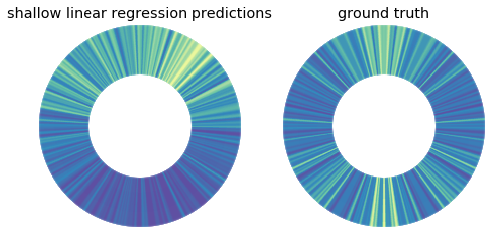

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
preds = np.squeeze(y_preds_shallow_linreg[0],axis=1)
hm_pred = cyclic_filter(mkheatmap_deg(preds, nbins=3600), gaussfilter(41))
#hm_pred = cyclic_filter(mkheatmap_deg(np.zeros(y_preds_shallow_linreg[0].shape)[:,0], nbins=3600)/5, gaussfilter(41))
hm_real = cyclic_filter(mkheatmap_deg(yte, nbins=3600), gaussfilter(41))
donut(axes[0], hm_pred/(len(yte)/400), bg=(201, 201), R=50, aapow=40);
axes[0].set_title('shallow linear regression predictions')
donut(axes[1], hm_real/(len(yte)/400), bg=(201, 201), R=50, aapow=40);
axes[1].set_title('ground truth')
plt.show()

## Linear regression through MLE of Von-Mises distribution


General form of Von-Mises distribution:

\begin{align}
   p(\phi; \mu, \kappa) = \frac{\exp{(\kappa \cos{(\phi-\mu)}})}{2\pi I_0(\kappa)}
\end{align}

In case of a fixed paramater $\kappa$ and simple linear regression, our model will look like:

\begin{align}
   p(\phi| x; \theta) = \frac{\exp{(\kappa \cos{(\phi - g(x,\theta))}})}{2\pi I_0(\kappa)},\\
   g(x,\theta) = \theta_1 x_1 + \dots + \theta_n x_n + \theta_{n+1}
\end{align}

Optimization function in case of a fixed $\kappa$:

\begin{align}
   argmax_{\theta} \sum_{i=1}^n{\cos{(\phi_i - g(x_i,\theta))}}
\end{align}

#### Examples of the Von-Mises distribution with different $\kappa$ and $\mu = 0$

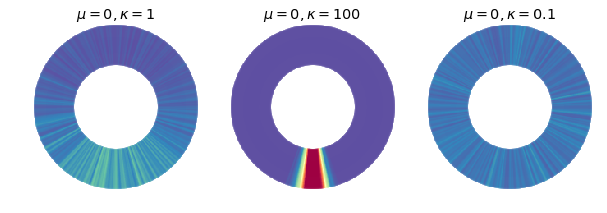

In [32]:
from numpy.random import vonmises
fig, axes = plt.subplots(1, 3, figsize=(10,4))
vm_01 = cyclic_filter(mkheatmap_deg(np.mod(np.rad2deg(vonmises(0,1,3000)),360), nbins=3600)/5, gaussfilter(41))
vm_001 = cyclic_filter(mkheatmap_deg(np.mod(np.rad2deg(vonmises(0,100,3000)),360), nbins=3600)/5, gaussfilter(41))
vm_010 = cyclic_filter(mkheatmap_deg(np.mod(np.rad2deg(vonmises(0,0.1,3000)),360), nbins=3600)/5, gaussfilter(41))
donut(axes[0], vm_01/(len(yte)/400), bg=(201, 201), R=50, aapow=40);
axes[0].set_title('$\mu=0, \kappa=1$')
donut(axes[1], vm_001/(len(yte)/400), bg=(201, 201), R=50, aapow=40);
axes[1].set_title('$\mu=0, \kappa=100$')
donut(axes[2], vm_010/(len(yte)/400), bg=(201, 201), R=50, aapow=40);
axes[2].set_title('$\mu=0, \kappa=0.1$')
plt.show()

In [33]:
def vm_model_tf():
    mu = tf.Variable(0.0, name='mu')
    return mu

def mle_vm_loss(phi_target, mu, radian_input=True):
    if radian_input:
        scaler = 1
    else:
        #convert to radians in input is in degrees
        scaler = 0.0174533
    loss = 1-tf.cos(scaler * (phi_target - mu))
    return tf.reduce_mean(loss)

In [34]:
def mle_vm_demo(mu_gt, kappa_gt, sample_size=1000, niters=1000, lr=0.001):

    print("ground truth Von-Mises params: mu=%f, kappa=%f" %(mu_gt, kappa_gt))

    vm_samples = vonmises(mu_gt, kappa_gt, sample_size)

    losses = []
    mu_preds = []
    
    tf.reset_default_graph()
    phi_tf = tf.placeholder(tf.float32, shape=None)
    mu_tf = vm_model_tf()
    mle_loss_tf = mle_vm_loss(phi_tf, mu_tf)
    train_step = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(mle_loss_tf)

    init_op = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init_op)
        for i in range(0,niters):
            loss, mu_pred, _ = sess.run([mle_loss_tf, mu_tf, train_step], feed_dict={phi_tf: vm_samples})
            losses.append(loss)
            mu_preds.append(mu_pred)

    kappa_pred = kappa_gt
    print("estimated Von-Mises params: mu=%f, kappa=%f" %(mu_pred, kappa_pred))
    
    fig, axes = plt.subplots(2, 2, figsize=(10,8))
    axes[0,0].plot(range(0, len(losses)), losses)
    axes[0,0].set_title('cost over epochs')
    axes[0,1].plot(range(0, len(mu_preds)), mu_preds)
    axes[0,1].set_title('mu over epochs')
    vm_gt = cyclic_filter(mkheatmap_deg(np.mod(np.rad2deg(vm_samples),360), nbins=3600)/5, gaussfilter(41))
    vm_pred = cyclic_filter(mkheatmap_deg(np.mod(np.rad2deg(vonmises(mu_pred,kappa_pred,sample_size)),360), nbins=3600)/5, gaussfilter(41))
    donut(axes[1,0], vm_gt/(len(yte)/400), bg=(201, 201), R=50, aapow=40);
    axes[1,0].set_title('gt distribution')
    donut(axes[1,1], vm_pred/(len(yte)/400), bg=(201, 201), R=50, aapow=40);
    axes[1,1].set_title('estimated distribution') 

ground truth Von-Mises params: mu=1.000000, kappa=1.000000
estimated Von-Mises params: mu=1.006647, kappa=1.000000


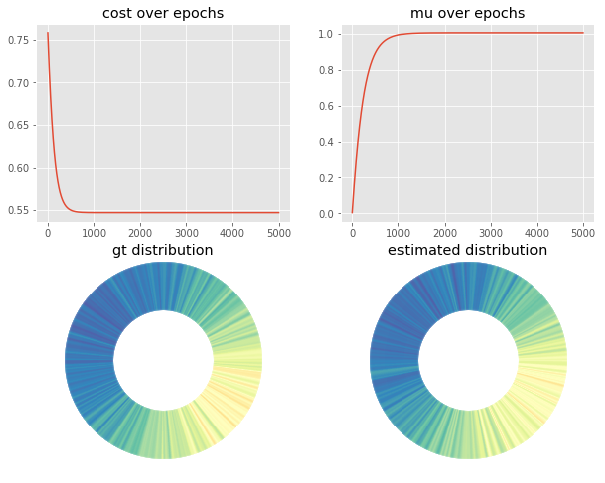

In [35]:
mle_vm_demo(mu_gt=1.0, kappa_gt=1, sample_size=10000, niters=5000, lr=0.01)

ground truth Von-Mises params: mu=0.500000, kappa=10.000000
estimated Von-Mises params: mu=0.500039, kappa=10.000000


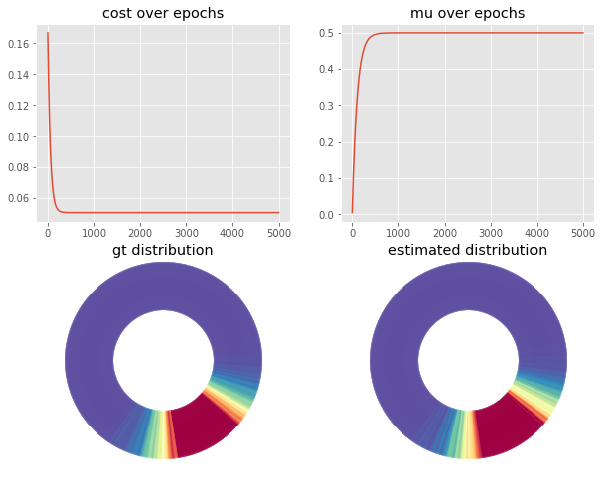

In [36]:
mle_vm_demo(mu_gt=0.5, kappa_gt=10, sample_size=10000, niters=5000, lr=0.01)

ground truth Von-Mises params: mu=3.140000, kappa=1.000000
estimated Von-Mises params: mu=3.130439, kappa=1.000000


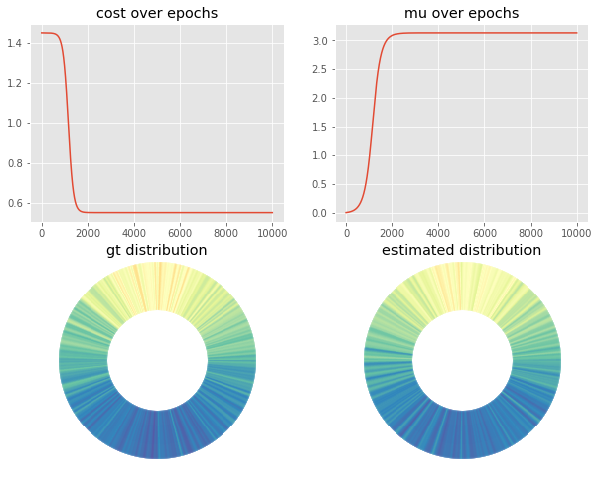

In [37]:
mle_vm_demo(mu_gt=3.14, kappa_gt=1.0, sample_size=10000, niters=10000, lr=0.01)

### Modified Bessel function of order 0

https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.i0.html#scipy.special.i0
http://mathworld.wolfram.com/ModifiedBesselFunctionoftheFirstKind.html

#### Using Taylor expansion around 

\begin{align}
I_0(x) \approx \sum_{m=0}^M \frac{(x^2/4)^m}{(m!)^2} 
\end{align}

In [38]:
from scipy.misc import factorial

def taylor_el(m):
    return 1/(4**m * factorial(m)**2)

coefs = np.asarray([taylor_el(m) for m in range(0,500)])

def bessel_approx(x, m=10):
    x = np.asarray(x).reshape(-1,1)
    deg = np.arange(0,m,1)*2
    x_tiled = np.tile(x, [1, m])
    deg_tiled = np.tile(deg, [x.shape[0],1])
    coef_tiled = np.tile(coefs[0:m].reshape(1,m), [x.shape[0],1])
    return np.sum(np.power(x_tiled, deg_tiled)*coef_tiled, axis=1)

def bessel_approx_tf(x, m=10):
    deg = tf.reshape(tf.range(0,m,1)*2, [1,-1])
    n_rows = tf.shape(x)[0]
    x_tiled = tf.tile(x, [1, m])
    deg_tiled = tf.tile(deg, [n_rows,1])
    coef_tiled = tf.tile(coefs[0:m].reshape(1,m), [n_rows,1])
    return  tf.reduce_sum(tf.pow(x_tiled, tf.to_double(deg_tiled))*coef_tiled, axis=1)

In [39]:
def bessel_approx_tf_demo(x_vals, m=20):
    tf.reset_default_graph()
    x = tf.placeholder(tf.float64, shape=[None, 1])
    bessel_tf = bessel_approx_tf(x, m=m)
    with tf.Session() as sess:
        vals = sess.run(bessel_tf, feed_dict={x:x_vals.reshape(-1, 1)})
    return vals

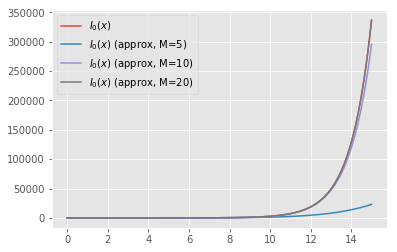

In [40]:
from scipy.special import i0 as bessel

x_vals = np.arange(0,15, 0.01)
y_vals = bessel(x_vals)
plt.plot(x_vals, y_vals, label='$I_0(x)$')
m=5
plt.plot(x_vals, bessel_approx_tf_demo(x_vals, m=m), label='$I_0(x)$ (approx, M=%d)'%m)
m=10
plt.plot(x_vals, bessel_approx_tf_demo(x_vals, m=m), label='$I_0(x)$ (approx, M=%d)'%m)
m=20
plt.plot(x_vals, bessel_approx_tf_demo(x_vals, m=m), label='$I_0(x)$ (approx, M=%d)'%m)
plt.legend()
plt.show()

\begin{align}
   p(\phi; \mu, \kappa) = \frac{\exp{(\kappa \cos{(\phi-\mu)}})}{2\pi I_0(\kappa)}
\end{align}

#### Check that our implementation is correct  by plotting corresponding density function of Von-Mises dist

In [41]:
def vm_pdf(vals, mu, kappa):
    return np.exp(kappa * np.cos(vals-mu)) / (2* np.pi * bessel_approx(kappa))

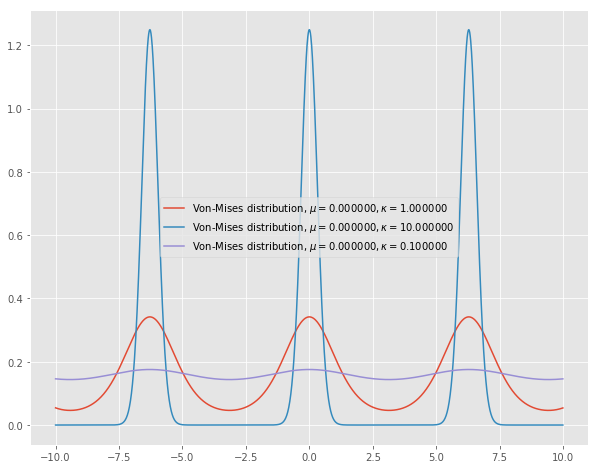

In [42]:
from scipy.special import i0 as bessel

x_vals = np.arange(-10,10, 0.01)

plt.figure(figsize=(10,8))
mu, kappa = [0.0, 1.0]
plt.plot(x_vals, vm_pdf(x_vals, mu, kappa), label='Von-Mises distribution, $\mu=%f, \kappa=%f$' %(mu, kappa))
mu, kappa = [0.0, 10.0]
plt.plot(x_vals, vm_pdf(x_vals, mu, kappa), label='Von-Mises distribution, $\mu=%f, \kappa=%f$' %(mu, kappa))
mu, kappa = [0.0, 0.1]
plt.plot(x_vals, vm_pdf(x_vals, mu, kappa), label='Von-Mises distribution, $\mu=%f, \kappa=%f$' %(mu, kappa))
plt.legend()
plt.show()

Log-likelihood formula:

\begin{align}
            \log \mathcal{L}(\mu, \kappa, X) = \sum_{i=1}^n{\log p(\phi_i| \mu, \kappa) } =\\ \sum_{i=1}^n{\kappa\cos{(\phi_i - \mu)}} - \sum_{i=1}^n{\log 2 \pi I_0(\kappa)}
\end{align}

In [43]:
def log_likelihood_np(phi_target, mu, kappa, radian_input=True):
    if radian_input:
        scaler = 1
    else:
        #convert to radians in input is in degrees
        scaler = 0.0174533 
    kappa = scaler * kappa
    likelihood = kappa * np.cos(scaler * (phi_target - mu)) - np.log(2*np.pi*bessel_approx(kappa))
    return np.mean(likelihood)

def mle_vm_loss(phi_target, mu, radian_input=True):
    if radian_input:
        scaler = 1
    else:
        #convert to radians in input is in degrees
        scaler = 0.0174533
    loss = 1-tf.cos(scaler * (phi_target - mu))
    return tf.reduce_mean(loss)

def log_likelihood_tf(x, mu, kappa, radian_input=True):
    kappa = tf.abs(tf.to_double(tf.reshape(kappa, [-1,1])))
    x = tf.to_double(x)
    mu = tf.to_double(mu)
    if radian_input:
        scaler = 1
    else:
        #convert to radians in input is in degrees
        scaler = 0.0174533 
    #kappa = scaler * kappa
    log_likelihood = kappa * tf.cos(scaler * (x - mu)) - tf.log(2*np.pi*bessel_approx_tf(kappa))
    # log_likelihood = tf.cos(scaler * (x - mu))
    return tf.reduce_mean(log_likelihood)

def log_likelihood_tf_demo(x, mu, kappa, radian_input=True):
    tf.reset_default_graph()
    mu = np.asarray(mu).reshape(-1,1)
    kappa = np.asarray(kappa).reshape(-1,1)
    x_tf = tf.placeholder(tf.float64, shape=[None, 1])
    mu_tf = tf.placeholder(tf.float64, shape=[None, 1])
    kappa_tf = tf.placeholder(tf.float64, shape=[None, 1])
    likelihood = log_likelihood_tf(x_tf, mu_tf, kappa_tf)
    with tf.Session() as sess:
        vals = sess.run(likelihood, feed_dict={x_tf:x.reshape(-1, 1), mu_tf: mu, kappa_tf: kappa} )
    return vals

In [44]:
mu, kappa = [0, 10.0]
samples = vonmises(mu, kappa, 5000).reshape(-1,1)
print("log-likelihood, numpy: %f" %log_likelihood_np(samples, mu, kappa))
print("log-likelihood, tensorflow: %f" %log_likelihood_tf_demo(samples, mu, kappa))

log-likelihood, numpy: -0.289175
log-likelihood, tensorflow: -0.289175


In [45]:
def vm_model_full_tf(mu_ini, kappa_ini):
    mu = tf.Variable(mu_ini, dtype=tf.float32, name='mu')
    kappa = tf.Variable(kappa_ini, dtype=tf.float32, name='kappa')
    return mu, kappa

In [46]:
def mle_vm_demo_full(mu_gt, kappa_gt, sample_size=1000, niters=1000, lr=0.001, 
                    mu_ini=0.0, kappa_ini=1.0, vis_sample_size=5000):

    print("ground truth Von-Mises params: mu=%f, kappa=%f" % (mu_gt, kappa_gt))

    vm_samples = vonmises(mu_gt, kappa_gt, sample_size)
    
    likelihoods = []
    mu_preds = []
    kappa_preds = []
    
    tf.reset_default_graph()
    phi_tf = tf.placeholder(tf.float32, shape=[None,1])
    mu_tf, kappa_tf = vm_model_full_tf(mu_ini, kappa_ini)
    loss = -log_likelihood_tf(phi_tf, mu_tf, kappa_tf)
    train_step = tf.train.AdadeltaOptimizer(learning_rate=lr).minimize(loss)

    init_op = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init_op)
        for i in range(0, niters):
            #vm_samples = vonmises(mu_gt, kappa_gt, sample_size)
            likelihood_pred, mu_pred, kappa_pred,  _ = sess.run([loss, mu_tf, kappa_tf, train_step], 
                                                     feed_dict={phi_tf: vm_samples.reshape(-1,1)})
            likelihoods.append(likelihood_pred)
            mu_preds.append(mu_pred)
            kappa_preds.append(kappa_pred)
    
    print("estimated Von-Mises params: mu=%f, kappa=%f" %(mu_pred, kappa_pred))
    
    kappa_pred = np.abs(kappa_pred)
    
    fig, axes = plt.subplots(2, 3, figsize=(15,10))
    axes[0,0].plot(range(0, len(likelihoods)), likelihoods)
    axes[0,0].set_title('$-\log \mathcal{L}(\mu, \kappa, X)$ over epochs')
    axes[0,1].plot(range(0, len(mu_preds)), mu_preds)
    axes[0,1].set_title('$\mu$ over epochs')
    axes[0,2].plot(range(0, len(kappa_preds)), kappa_preds)
    axes[0,2].set_title('$\kappa$ over epochs')
    vm_gt = cyclic_filter(mkheatmap_deg(np.mod(np.rad2deg(vonmises(mu_gt,kappa_gt,vis_sample_size)),360), nbins=3600), gaussfilter(41))
    vm_ini = cyclic_filter(mkheatmap_deg(np.mod(np.rad2deg(vonmises(mu_ini,kappa_ini,vis_sample_size)),360), nbins=3600), gaussfilter(41))
    vm_pred = cyclic_filter(mkheatmap_deg(np.mod(np.rad2deg(vonmises(mu_pred,kappa_pred,vis_sample_size)),360), nbins=3600), gaussfilter(41))
    donut(axes[1,0], vm_gt/(len(yte)/400), bg=(201, 201), R=50, aapow=40);
    axes[1,0].set_title('gt distribution $\mu=%.2f, \kappa=%.2f$' %(mu_gt, kappa_gt), fontsize=10)
    donut(axes[1,1], vm_pred/(len(yte)/400), bg=(201, 201), R=50, aapow=40);
    axes[1,1].set_title('estimated distribution $\mu=%.2f, \kappa=%.2f$' %(mu_pred, kappa_pred), fontsize=10)
    donut(axes[1,2], vm_ini/(len(yte)/400), bg=(201, 201), R=50, aapow=40);
    axes[1,2].set_title('initial distribution $\mu=%.2f, \kappa=%.2f$' %(mu_ini, kappa_ini), fontsize=10)

ground truth Von-Mises params: mu=2.000000, kappa=1.000000
estimated Von-Mises params: mu=2.004003, kappa=1.015038


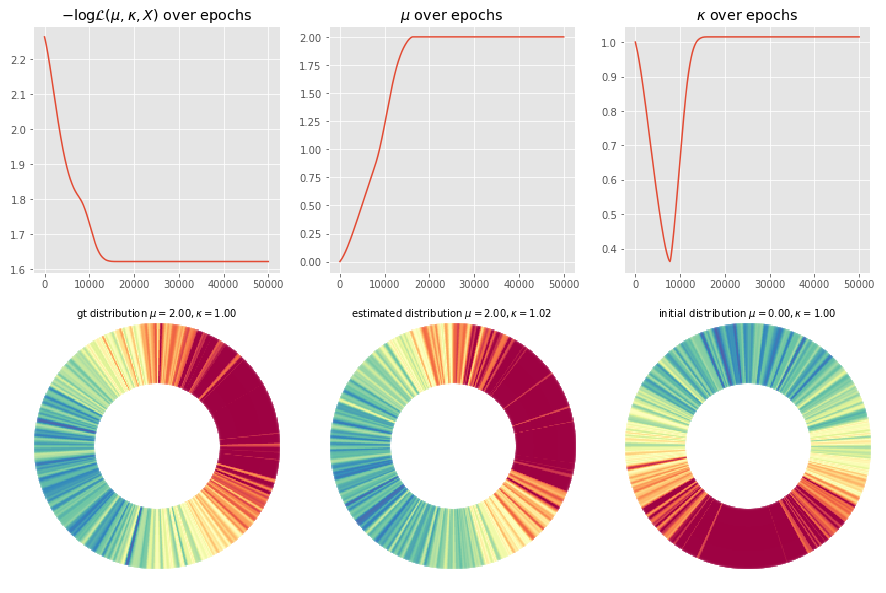

In [47]:
mle_vm_demo_full(mu_gt=2.0, kappa_gt=1.0, sample_size=50000, niters=50000, lr=0.1)

ground truth Von-Mises params: mu=3.140000, kappa=10.000000
estimated Von-Mises params: mu=3.140756, kappa=9.047030


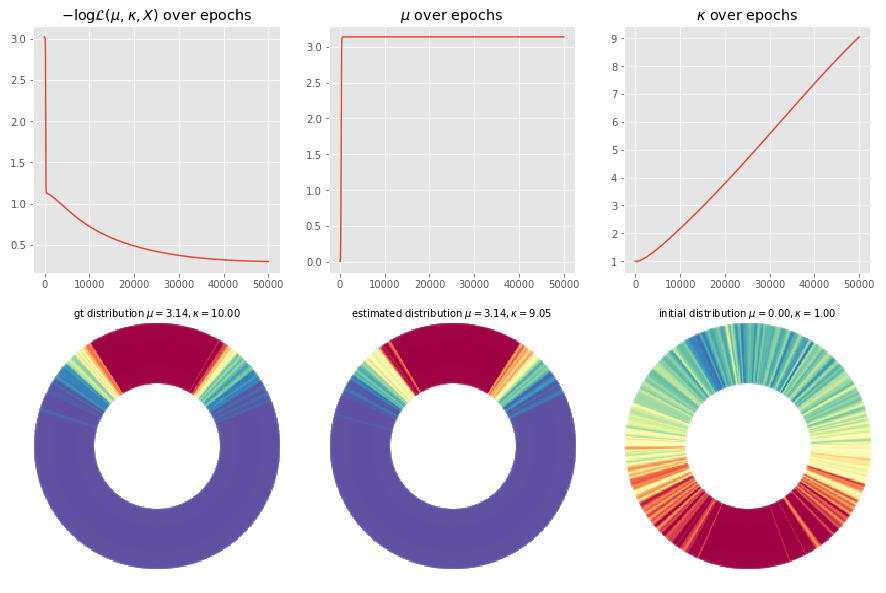

In [48]:
mle_vm_demo_full(mu_gt=3.14, kappa_gt=10.0, sample_size=50000, niters=50000, lr=0.1)

ground truth Von-Mises params: mu=3.140000, kappa=0.100000
estimated Von-Mises params: mu=3.016170, kappa=0.094975


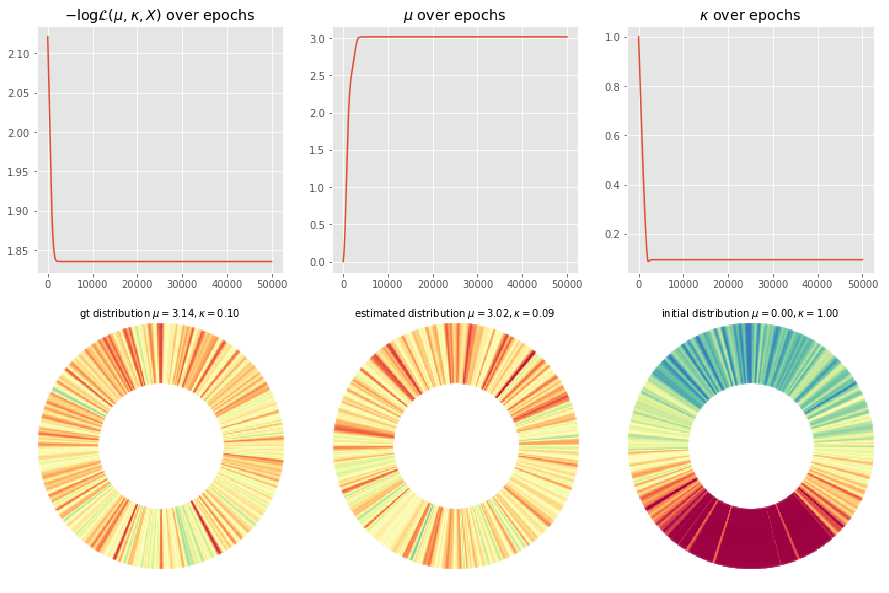

In [49]:
mle_vm_demo_full(mu_gt=3.14, kappa_gt=0.1, sample_size=50000, niters=50000, lr=1.0)

### MLE estimation for TownCentre headpose

In [50]:
def shallow_linear_regression_model(x):
    x_flat = tf.contrib.layers.flatten(x)
    W_fc = weight_variable([3*46*46, 1])
    b_fc = bias_variable([1])
    y = tf.matmul(x_flat, W_fc) + b_fc
    return y

In [51]:
from lbtoolbox.util import batched

def mad_loss(y_target, y_pred):
    loss = tf.abs(y_target - y_pred)
    return loss

def input_tensors():
    x = tf.placeholder(tf.float32, shape=[None, 3, 46, 46])
    y_target = tf.placeholder(tf.float32, shape=[None, 1])
    return x, y_target

def adadelta_optimizer(loss):
    opt = tf.train.AdadeltaOptimizer(rho=0.95, learning_rate=1.0, epsilon=1e-7).minimize(loss)
    return opt

def dotrain_eval_tf(Xtr, ytr, Xte, yte, nruns = 5, nepochs=50, batchsize=100, debug_print=False):
    y_preds = []
    kappa_preds = []
    Xte_aug, yte_aug = aug.augbatch_train(Xte, yte)
    yte_aug = yte_aug[:,None]
    runs_epochs_losses = []
    for run_id in range(0, nruns):
        with tf.Session() as sess:
            sess.run(init_op)
            epochs_losses = []
            for epoch_id in range(0, nepochs):
                epoch_losses = []
                for Xb, yb in batched(batchsize, Xtr, ytr, shuf=True):
                    Xb_aug, yb_aug = aug.augbatch_train(Xb, yb)
                    yb_aug = yb_aug.reshape(-1,1)
                    _, preds, batch_losses = sess.run([train_step, y_pred_tf, loss_tf], 
                                                      feed_dict={x_tf: Xb_aug, y_target_tf: yb_aug.reshape(-1,1)})
                    epoch_losses.append(np.mean(batch_losses))
                mean_epoch_loss = np.mean(epoch_losses)
                epochs_losses.append(mean_epoch_loss)
                if debug_print:
                    print("epoch %d finished. mean epoch loss: %f" % (epoch_id, mean_epoch_loss))
            y_pred, kappa_pred = sess.run([y_pred_tf, kappa_tf], feed_dict={x_tf:Xte_aug})
            y_preds.append(y_pred)
            kappa_preds.append(kappa_pred)
        runs_epochs_losses.append(epochs_losses)
        print("run %d finished" % run_id)
    return y_preds, kappa_preds, runs_epochs_losses

#### Setting global params

In [52]:
nruns=1
nepochs=100

In [53]:
tf.reset_default_graph()

fixed_kappa=1

x_tf, y_target_tf = input_tensors()
#y_preds_tf = tf.placeholder(tf.float64, shape=[None, 1])
y_pred_tf = shallow_linear_regression_model(x_tf)
#loss_tf = -log_likelihood_tf(y_target_tf, y_pred_tf, 1.0, radian_input=False)
kappa_tf = shallow_linear_regression_model(x_tf)
loss_tf = mad_loss(y_target_tf, y_pred_tf)
#loss_tf = -log_likelihood_tf(y_target_tf, y_pred_tf, kappa_tf, radian_input=False)
#loss_tf = mad_loss(y_target_tf, y_pred_tf)
#loss_tf = mle_vm_loss(phi_target=y_target_tf,  mu=y_pred_tf, radian_input=False)
train_step = tf.train.AdadeltaOptimizer(learning_rate=1.0).minimize(loss_tf)

init_op = tf.global_variables_initializer()

y_preds_lr_mae, kappa_preds_linreg, losses_plots = dotrain_eval_tf(Xtr, ytr, Xte, yte, debug_print=False, nruns=nruns, nepochs=nepochs)

run 0 finished


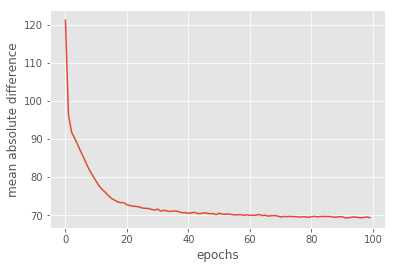

In [54]:
import matplotlib.pyplot as plt

plt.plot(range(0, len(losses_plots[0])), losses_plots[0])
plt.xlabel('epochs')
plt.ylabel('mean absolute difference')
plt.show()

In [55]:
Xte_aug, yte_aug = aug.augbatch_train(Xte, yte)
yte_aug = yte_aug[:,None]
show_errs_deg(y_preds_lr_mae, yte_aug)
test_likelihood = np.exp(log_likelihood_np(yte_aug, y_preds_lr_mae, fixed_kappa))
print("Likelihood: %f"%test_likelihood)

Error: 65.76°±46.96°
Stdev:  0.00°± 0.00°
Likelihood: 0.124488


####  linear regression, optmizing for VM-MLE loss with fixed $\kappa$

In [56]:
tf.reset_default_graph()

fixed_kappa=1.0

x_tf, y_target_tf = input_tensors()
#y_preds_tf = tf.placeholder(tf.float64, shape=[None, 1])
y_pred_tf = shallow_linear_regression_model(x_tf)
#loss_tf = -log_likelihood_tf(y_target_tf, y_pred_tf, 1.0, radian_input=False)
kappa_tf = shallow_linear_regression_model(x_tf)
#loss_tf = mad_loss(y_target_tf, y_pred_tf)
loss_tf = -log_likelihood_tf(y_target_tf, y_pred_tf, fixed_kappa, radian_input=False)
train_step = tf.train.AdadeltaOptimizer(learning_rate=1.0).minimize(loss_tf)
init_op = tf.global_variables_initializer()
y_preds_lr_mle_fixed, kappa_preds, losses_plots = dotrain_eval_tf(Xtr, ytr, Xte, yte, debug_print=False, nruns=nruns, nepochs=nepochs)

run 0 finished


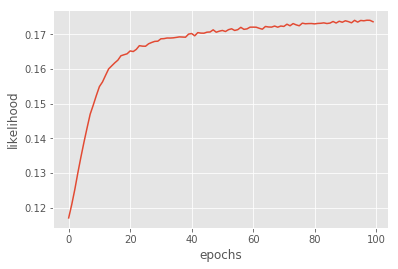

In [57]:
import matplotlib.pyplot as plt

plt.plot(range(0, len(losses_plots[0])), np.exp(-np.asarray(losses_plots[0])))
plt.xlabel('epochs')
plt.ylabel('likelihood')
plt.show()

In [98]:
Xte_aug, yte_aug = aug.augbatch_train(Xte, yte)
yte_aug = yte_aug[:,None]
show_errs_deg(y_preds_lr_mle_fixed, yte_aug)
test_likelihood_kappa1 = np.exp(log_likelihood_np(yte_aug, y_preds_lr_mle_fixed, fixed_kappa))
test_likelihood_kappa01 = np.exp(log_likelihood_np(yte_aug, y_preds_lr_mle_fixed, fixed_kappa*0.1))
test_likelihood_kappa10 = np.exp(log_likelihood_np(yte_aug, y_preds_lr_mle_fixed, fixed_kappa*10.0))
print("Likelihood (kappa=1.0): %f"%test_likelihood_kappa1)
print("Likelihood (kappa=0.1): %f"%test_likelihood_kappa01)
print("Likelihood (kappa=10.0): %f"%test_likelihood_kappa10)

Error: 64.44°±47.64°
Stdev:  0.00°± 0.00°
Likelihood (kappa=1.0): 0.126248
Likelihood (kappa=0.1): 0.158826
Likelihood (kappa=10.0): 0.000059


####  linear regression, optmizing for VM-MLE loss (with $\kappa$ prediction)

In [85]:
tf.reset_default_graph()

x_tf, y_target_tf = input_tensors()
#y_preds_tf = tf.placeholder(tf.float64, shape=[None, 1])
y_pred_tf = shallow_linear_regression_model(x_tf)
#loss_tf = -log_likelihood_tf(y_target_tf, y_pred_tf, 1.0, radian_input=False)
kappa_tf = shallow_linear_regression_model(x_tf)
#loss_tf = mad_loss(y_target_tf, y_pred_tf)
loss_tf = -log_likelihood_tf(y_target_tf, y_pred_tf, kappa_tf, radian_input=False)
train_step = tf.train.AdadeltaOptimizer(learning_rate=1.0).minimize(loss_tf)
init_op = tf.global_variables_initializer()
y_preds_lr_mle_full1, kappa_full1, losses_plots_full1 = dotrain_eval_tf(Xtr, ytr, Xte, yte, debug_print=False, nruns=nruns, nepochs=nepochs)

run 0 finished


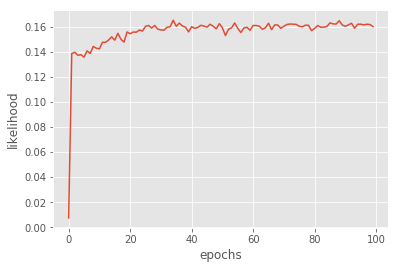

In [86]:
import matplotlib.pyplot as plt

plt.plot(range(0, len(losses_plots_full1[0])), np.exp(-np.asarray(losses_plots_full1[0])))
plt.xlabel('epochs')
plt.ylabel('likelihood')
plt.show()

In [108]:
Xte_aug, yte_aug = aug.augbatch_train(Xte, yte)
yte_aug = yte_aug[:,None]
show_errs_deg(y_preds_lr_mle_full1, yte_aug)
test_likelihood = np.exp(log_likelihood_np(yte_aug, y_preds_lr_mle_full1, np.abs(kappa_full1)))
print("Likelihood: %f"%test_likelihood)
print("Mean kappa : %f" % np.mean(np.abs(kappa_full1)))

Error: 67.46°±47.12°
Stdev:  0.00°± 0.00°
Likelihood: 0.125689
Mean kappa : 0.870968


#### Same with lr=0.1

In [88]:
tf.reset_default_graph()

x_tf, y_target_tf = input_tensors()
#y_preds_tf = tf.placeholder(tf.float64, shape=[None, 1])
y_pred_tf = shallow_linear_regression_model(x_tf)
#loss_tf = -log_likelihood_tf(y_target_tf, y_pred_tf, 1.0, radian_input=False)
kappa_tf = shallow_linear_regression_model(x_tf)
#loss_tf = mad_loss(y_target_tf, y_pred_tf)
loss_tf = -log_likelihood_tf(y_target_tf, y_pred_tf, kappa_tf, radian_input=False)
train_step = tf.train.AdadeltaOptimizer(learning_rate=0.1).minimize(loss_tf)
init_op = tf.global_variables_initializer()
y_preds_lr_mle_full01, kappa_full01, losses_plots_full01 = dotrain_eval_tf(Xtr, ytr, Xte, yte, debug_print=False, nruns=nruns, nepochs=nepochs)

run 0 finished


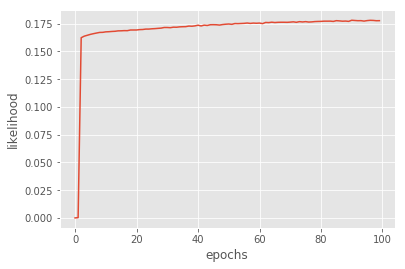

In [90]:
import matplotlib.pyplot as plt

plt.plot(range(0, len(losses_plots_full01[0])), np.exp(-np.asarray(losses_plots_full01[0])))
plt.xlabel('epochs')
plt.ylabel('likelihood')
plt.show()

In [107]:
Xte_aug, yte_aug = aug.augbatch_train(Xte, yte)
yte_aug = yte_aug[:,None]
show_errs_deg(y_preds_lr_mle_full, yte_aug)
test_likelihood = np.exp(log_likelihood_np(yte_aug, y_preds_lr_mle_full01, np.abs(kappa_full01)))
print("Likelihood: %f"%test_likelihood)
print("Mean kappa : %f" % np.mean(np.abs(kappa_full01)))

Error: 85.64°±62.02°
Stdev:  0.00°± 0.00°
Likelihood: 0.137787
Mean kappa : 0.615582


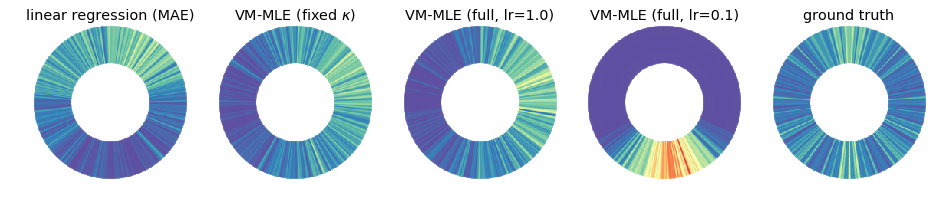

In [104]:
fig, axes = plt.subplots(1, 5, figsize=(16,10))
hm_pred_lr_mae = cyclic_filter(mkheatmap_deg(np.concatenate(y_preds_lr_mae)[:,0], nbins=3600)/nruns, gaussfilter(41))
hm_pred_lr_mle_fixed = cyclic_filter(mkheatmap_deg(np.concatenate(y_preds_lr_mle_fixed)[:,0], nbins=3600)/nruns, gaussfilter(41))
hm_pred_lr_mle_full1 = cyclic_filter(mkheatmap_deg(np.concatenate(y_preds_lr_mle_full1)[:,0], nbins=3600)/nruns, gaussfilter(41))
hm_pred_lr_mle_full01 = cyclic_filter(mkheatmap_deg(np.concatenate(y_preds_lr_mle_full01)[:,0], nbins=3600)/nruns, gaussfilter(41))
hm_real = cyclic_filter(mkheatmap_deg(yte, nbins=3600), gaussfilter(41))
donut(axes[0], hm_pred_lr_mae/(len(yte)/400), bg=(201, 201), R=50, aapow=40);
axes[0].set_title('linear regression (MAE)')
donut(axes[1], hm_pred_lr_mle_fixed/(len(yte)/400), bg=(201, 201), R=50, aapow=40);
axes[1].set_title('VM-MLE (fixed $\kappa$)')
donut(axes[2], hm_pred_lr_mle_full1/(len(yte)/400), bg=(201, 201), R=50, aapow=40);
axes[2].set_title('VM-MLE (full, lr=1.0)')
donut(axes[3], hm_pred_lr_mle_full01/(len(yte)/400), bg=(201, 201), R=50, aapow=40);
axes[3].set_title('VM-MLE (full, lr=0.1)')
donut(axes[4], hm_real/(len(yte)/400), bg=(201, 201), R=50, aapow=40);
axes[4].set_title('ground truth')
plt.savefig('/Users/sergey/BiternionNet/biternion.png')

## Deep Linear Regression

In [ ]:
nets_linreg = [mknet_updated(df.Linear(512, 1, init=df.init.const(0))) for _ in range(5)]
# print('{:.3f}M params'.format(count_params(nets_linreg[0])/1000000))

In [ ]:
trains_linreg = [dotrain(net, df.MADCriterion(), aug, Xtr, ytr[:,None]) for net in nets_linreg]

In [ ]:
for model in nets_linreg:
    dostats(model, aug, Xtr, batchsize=1000)

In [ ]:
y_preds_linreg = [dopred_deg(net, aug, Xte) for net in nets_linreg]

In [ ]:
show_errs_deg(y_preds_linreg, yte[:,None])

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
hm_pred = cyclic_filter(mkheatmap_deg(np.concatenate(y_preds_linreg)[:,0], nbins=3600)/5, gaussfilter(41))
hm_real = cyclic_filter(mkheatmap_deg(yte, nbins=3600), gaussfilter(41))
donut(axes[0], hm_pred/(len(yte)/400), bg=(201, 201), R=50, aapow=40);
donut(axes[1], hm_real/(len(yte)/400), bg=(201, 201), R=50, aapow=40);

## Linear Regression in Radians

This experiment is not present in the paper, but just in order to prove that the improvements do not lie in the smaller output range of biternions, here is the regression of the angles in radians, i.e. a small range. Spoiler: the results are the same as for degrees.

In [ ]:
#nets_linreg_rad = [mknet(df.Linear(512, 1, initW=df.init.const(0))) for _ in range(5)]
nets_shallow_linreg = [df.Sequential(
    Flatten(),
    df.Linear(3*46*46, 1, init=df.init.const(0)),
) for _ in range(5)]
#print('{:.3f}M params'.format(count_params(nets_linreg_rad[0])/1000000))

In [ ]:
trains_linreg_rad = [dotrain(net, df.MADCriterion(), aug, Xtr, np.deg2rad(ytr[:,None])) for net in nets_shallow_linreg]

In [ ]:
for model in nets_shallow_linreg:
    dostats(model, aug, Xtr, batchsize=1000)

In [ ]:
def ensemble_radians(angles):
    return np.arctan2(np.mean(np.sin(angles), axis=0), np.mean(np.cos(angles), axis=0))

In [ ]:
def dopred_rad(model, aug, X, batchsize=100):
    return dopred(model, aug, X, ensembling=ensemble_radians, output2preds=lambda x: x, batchsize=batchsize)

In [ ]:
y_preds_linreg_rad = [dopred_rad(net, aug, Xte) for net in nets_shallow_linreg]

In [ ]:
show_errs_deg(np.rad2deg(y_preds_linreg_rad), yte[:,None])

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
hm_pred = cyclic_filter(mkheatmap_deg(np.concatenate(np.rad2deg(y_preds_linreg_rad))[:,0], nbins=3600)/5, gaussfilter(41))
hm_real = cyclic_filter(mkheatmap_deg(yte, nbins=3600), gaussfilter(41))
donut(axes[0], hm_pred/(len(yte)/400), bg=(201, 201), R=50, aapow=40);
donut(axes[1], hm_real/(len(yte)/400), bg=(201, 201), R=50, aapow=40);

## Deep Linear Regression with Modulo

In [ ]:
nets_linreg_mod = [mknet(df.Linear(512, 1, initW=df.init.const(0))) for _ in range(5)]
print('{:.3f}M params'.format(count_params(nets_linreg_mod[0])/1000000))

In [ ]:
class ModuloMADCriterion(df.Criterion):
    def symb_forward(self, symb_in, symb_tgt):
        self._assert_same_dim(symb_in, symb_tgt)

        return df.T.mean(abs(symb_in - symb_tgt) % 360)

In [ ]:
trains_linreg_mod = [dotrain(net, ModuloMADCriterion(), aug, Xtr, ytr[:,None]) for net in nets_linreg_mod]

In [ ]:
for model in nets_linreg_mod:
    dostats(model, aug, Xtr, batchsize=1000)

In [ ]:
y_preds_linreg_mod = [dopred_deg(net, aug, Xte) for net in nets_linreg_mod]

In [ ]:
show_errs_deg(y_preds_linreg_mod, yte[:,None])

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
hm_pred = cyclic_filter(mkheatmap_deg(np.concatenate(y_preds_linreg_mod)[:,0], nbins=3600)/5, gaussfilter(41))
hm_real = cyclic_filter(mkheatmap_deg(yte, nbins=3600), gaussfilter(41))
donut(axes[0], hm_pred/(len(yte)/400), bg=(201, 201), R=50, aapow=40);
donut(axes[1], hm_real/(len(yte)/400), bg=(201, 201), R=50, aapow=40);

As you can see, the `mod` in the criterion doesn't seem to change anything at all compared to the linear case. That's because our initialization of the last layer makes it output all-zeros in the first run, and from thereon it will be "pulled upwards" so as to output only values within [0,360] almost all the time. Within this range, `mod` is exactly a no-op, so nothing bad happens.

But actually, even when forcing the network outside this "nice" range initially (using large initialization of the output layer), `mod` will behave the same as no-`mod`. Here is such a large initialization as reference, it's left as an exercise to the reader (as if there was one, heh) to do the same experiment without the `mod`.

In [ ]:
net_linreg_mod2 = mknet(df.Linear(512, 1, initW=df.init.normal(20)))
net_linreg_mod2.forward(aug.augbatch_train(Xtr[:10])[0]).T

In [ ]:
train_linreg_mod2 = dotrain(net_linreg_mod2, ModuloMADCriterion(), aug, Xtr, ytr[:,None])

## Von-Mises Criterion

In [ ]:
class VonMisesCriterion(df.Criterion):
    def __init__(self, kappa, radians=True):
        df.Criterion.__init__(self)

        self.kappa = kappa
        self.torad = 1 if radians else 0.0174532925

    def symb_forward(self, symb_in, symb_tgt):
        delta_rad = self.torad * (symb_in - symb_tgt)
        C = np.exp(2*self.kappa)
        return df.T.mean(C - df.T.exp(self.kappa * (1+df.T.cos(delta_rad))))

In [ ]:
nets_linreg_vm = [mknet(df.Linear(512, 1, initW=df.init.const(0))) for _ in range(5)]
print('{:.3f}M params'.format(count_params(nets_linreg_vm[0])/1000000))

In [ ]:
trains_linreg_vm = [dotrain(net, VonMisesCriterion(0.5, radians=False), aug, Xtr, ytr[:,None]) for net in nets_linreg_vm]

In [ ]:
for model in nets_linreg_vm:
    dostats(model, aug, Xtr, batchsize=1000)

In [ ]:
y_preds_linreg_vm = [dopred_deg(net, aug, Xte) for net in nets_linreg_vm]

In [ ]:
show_errs_deg(y_preds_linreg_vm, yte[:,None])

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
hm_pred = cyclic_filter(mkheatmap_deg(np.concatenate(y_preds_linreg_vm)[:,0], nbins=3600)/5, gaussfilter(41))
hm_real = cyclic_filter(mkheatmap_deg(yte, nbins=3600), gaussfilter(41))
donut(axes[0], hm_pred/(len(yte)/400), bg=(201, 201), R=50, aapow=40);
donut(axes[1], hm_real/(len(yte)/400), bg=(201, 201), R=50, aapow=40);

## Biternion Output

For the biternion output, no matter the criterion, we need a few common functions. First, the biternion layer itself (simply normalization), and utilities to convert angles to 2D vectors ("biternions") and vice-versa.

In [ ]:
class Biternion(df.Module):
    def symb_forward(self, symb_in):
        return symb_in / df.T.sqrt((symb_in**2).sum(axis=1, keepdims=True))

In [ ]:
def deg2bit(angles_deg):
    angles_rad = np.deg2rad(angles_deg)
    return np.array([np.cos(angles_rad), np.sin(angles_rad)]).T

In [ ]:
def bit2deg(angles_bit):
    return (np.rad2deg(np.arctan2(angles_bit[:,1], angles_bit[:,0])) + 360) % 360

### Biternion with Cosine Criterion

In [ ]:
class CosineCriterion(df.Criterion):
    def symb_forward(self, symb_in, symb_tgt):
        # For normalized `p_t_given_x` and `t`, dot-product (batched)
        # outputs a cosine value, i.e. between -1 (worst) and 1 (best)
        cos_angles = df.T.batched_dot(symb_in, symb_tgt)

        # Rescale to a cost going from 2 (worst) to 0 (best) each, then take mean.
        return df.T.mean(1 - cos_angles)

In [ ]:
#nets_linreg_bt_cos = [mknet(df.Linear(512, 2, initW=df.init.normal(0.01)), Biternion()) for _ in range(5)]
nets_linreg_bt_cos = [df.Sequential(
    Flatten(),
    df.Linear(3*46*46, 2, init=df.init.const(0)),
) for _ in range(5)]
#print('{:.3f}M params'.format(count_params(nets_linreg_bt_cos[0])/1000000))

In [ ]:
trains_linreg_bt_cos = [dotrain(net, CosineCriterion(), aug, Xtr, deg2bit(ytr)) for net in nets_linreg_bt_cos]

In [ ]:
for model in nets_linreg_bt_cos:
    dostats(model, aug, Xtr, batchsize=1000)

In [ ]:
y_preds_linreg_bt_cos = [bit2deg(dopred_deg(net, aug, Xte)) for net in nets_linreg_bt_cos]

In [ ]:
show_errs_deg(y_preds_linreg_bt_cos, yte)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
hm_pred = cyclic_filter(mkheatmap_deg(np.concatenate(y_preds_linreg_bt_cos), nbins=3600)/5, gaussfilter(41))
hm_real = cyclic_filter(mkheatmap_deg(yte, nbins=3600), gaussfilter(41))
donut(axes[0], hm_pred/(len(yte)/400), bg=(201, 201), R=50, aapow=40);
donut(axes[1], hm_real/(len(yte)/400), bg=(201, 201), R=50, aapow=40);

### Biternion with Von-Mises Criterion

In [ ]:
class VonMisesBiternionCriterion(df.Criterion):
    def __init__(self, kappa):
        df.Criterion.__init__(self)
        self.kappa = kappa

    def symb_forward(self, symb_in, symb_tgt):
        cos_angles = df.T.batched_dot(symb_in, symb_tgt)

        # This is the only difference to the pure `CosineCriterion`.
        # Obviously, they could be in the same class, but I separate them here for narration.
        cos_angles = df.T.exp(self.kappa * (cos_angles - 1))

        return df.T.mean(1 - cos_angles)

In [ ]:
nets_linreg_bt_vm = [mknet(df.Linear(512, 2, initW=df.init.normal(0.01)), Biternion()) for _ in range(5)]
print('{:.3f}M params'.format(count_params(nets_linreg_bt_vm[0])/1000000))

In [ ]:
trains_linreg_bt_vm = [dotrain(net, VonMisesBiternionCriterion(1), aug, Xtr, deg2bit(ytr)) for net in nets_linreg_bt_vm]

In [ ]:
for model in nets_linreg_bt_vm:
    dostats(model, aug, Xtr, batchsize=1000)

In [ ]:
y_preds_linreg_bt_vm = [bit2deg(dopred_deg(net, aug, Xte)) for net in nets_linreg_bt_vm]

In [ ]:
show_errs_deg(y_preds_linreg_bt_vm, yte)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
hm_pred = cyclic_filter(mkheatmap_deg(np.concatenate(y_preds_linreg_bt_vm), nbins=3600)/5, gaussfilter(41))
hm_real = cyclic_filter(mkheatmap_deg(yte, nbins=3600), gaussfilter(41))
donut(axes[0], hm_pred/(len(yte)/400), bg=(201, 201), R=50, aapow=40);
donut(axes[1], hm_real/(len(yte)/400), bg=(201, 201), R=50, aapow=40);

# Regression using weak (class) labels

This second half of the notebook is about reproducing Table 4 of Section 5 of the paper, i.e. investigating how well distributed of an output we can learn from discrete ("weak") class labels. For this, we will quantize the TownCentre labels into various amounts of weak classes.

In [ ]:
def quantize_labels(y, ranges):
    q = np.empty(y.shape, dtype=np.int32)
    for i in range(len(ranges)-1):
        # Check for "that" jump.
        if ranges[i] < ranges[i+1]:
            q[(ranges[i] <= y) & (y < ranges[i+1])] = i
        else:
            q[(ranges[i] <= y) | (y < ranges[i+1])] = i
    return q

The following function simply does softmax prediction, i.e. returns class-probabilities for each sample.

In [ ]:
def dopred_sm(model, aug, X, batchsize=100):
    return dopred(model, aug, X, ensembling=lambda p_ys: np.mean(p_ys, axis=0), output2preds=lambda x: x, batchsize=batchsize)

Convert class-probabilities as returned by `dopred_sm` into angle predictions in degrees by simply using the class-centre.

In [ ]:
def probs2deg_centre(p_y, centres):
    return centres[np.argmax(p_y, axis=-1)]

Convert class-probabilities as returned by `dopred_sm` into angle predictions in degrees by quadratically interpolating between the highest-probability class and its two neighbors, and then predicting the max of that parabola.

In [ ]:
# http://stackoverflow.com/questions/717762/how-to-calculate-the-vertex-of-a-parabola-given-three-points
def parabola_vertex(x, y):
    x1, x2, x3 = x
    y1, y2, y3 = y
    denom = (x1 - x2) * (x1 - x3) * (x2 - x3)
    A = (x3 * (y2 - y1) + x2 * (y1 - y3) + x1 * (y3 - y2)) / denom
    B = (x3 * x3 * (y1 - y2) + x2 * x2 * (y3 - y1) + x1 * x1 * (y2 - y3)) / denom
    C = (x2 * x3 * (x2 - x3) * y1 + x3 * x1 * (x3 - x1) * y2 + x1 * x2 * (x1 - x2) * y3) / denom

    return -B / (2*A), C - B*B / (4*A)

#parabola_vertex(1,1, 0,2, -1,1)
#parabola_vertex([1, 0, -1], [1, 2, 1])

In [ ]:
def prob2deg_quadint(p_y, centres):
    i = np.argmax(p_y)
    if i == 0:
        return parabola_vertex([centres[-1] - 360, centres[0], centres[1]], p_y[[-1, 0, 1]])
    elif i == len(centres)-1:
        return parabola_vertex([centres[-2], centres[-1], centres[0] + 360], p_y[[-2, -1, 0]])
    else:
        return parabola_vertex(centres[[i-1, i, i+1]], p_y[[i-1, i, i+1]])

def probs2deg_quadint(preds, centres):
    return np.array([prob2deg_quadint(p, centres)[0] for p in preds])

## 3 Orientation bins

In [ ]:
q3_borders = np.array([0, 120, 240, 361], dtype=df.floatX)
q3_centres = np.array([ 60,  180, 320  ], dtype=df.floatX)

### Class-centre predictions

In [ ]:
nets_q3_sm = [mknet(df.Linear(512, 3, initW=df.init.const(0)), df.SoftMax()) for _ in range(5)]
trains_q3_sm = [dotrain(net, df.ClassNLLCriterion(), aug, Xtr, quantize_labels(ytr, q3_borders)) for net in nets_q3_sm]
for model in nets_q3_sm:
    dostats(model, aug, Xtr, batchsize=1000)
y_preds_q3_sm = [dopred_sm(net, aug, Xte) for net in nets_q3_sm]

In [ ]:
show_errs_deg(probs2deg_centre(y_preds_q3_sm, q3_centres), yte)

### Probabilistic class interpolation predictions

In [ ]:
show_errs_deg([probs2deg_quadint(p_y, q3_centres) for p_y in y_preds_q3_sm], yte)

### Deep linear regression

In [ ]:
nets_q3_lr = [mknet(df.Linear(512, 1, initW=df.init.const(0))) for _ in range(5)]
trains_q3_lr = [dotrain(net, df.MADCriterion(), aug, Xtr, q3_centres[quantize_labels(ytr, q3_borders),None]) for net in nets_q3_lr]
for model in nets_q3_lr:
    dostats(model, aug, Xtr, batchsize=1000)
y_preds_q3_lr = [dopred_deg(net, aug, Xte) for net in nets_q3_lr]

In [ ]:
show_errs_deg(y_preds_q3_lr, yte[:,None])

### Deep linear regression + Von-Mises

In [ ]:
nets_q3_lr_vm = [mknet(df.Linear(512, 1, initW=df.init.const(0))) for _ in range(5)]
trains_q3_lr_vm = [dotrain(net, VonMisesCriterion(1, radians=False), aug, Xtr, q3_centres[quantize_labels(ytr, q3_borders),None]) for net in nets_q3_lr_vm]
for model in nets_q3_lr_vm:
    dostats(model, aug, Xtr, batchsize=1000)
y_preds_q3_lr_vm = [dopred_deg(net, aug, Xte) for net in nets_q3_lr_vm]

In [ ]:
show_errs_deg(y_preds_q3_lr_vm, yte[:,None])

### Biternions

In [ ]:
nets_q3_bt = [mknet(df.Linear(512, 2, initW=df.init.normal(0.01)), Biternion()) for _ in range(5)]
trains_q3_bt = [dotrain(net, CosineCriterion(), aug, Xtr, deg2bit(q3_centres[quantize_labels(ytr, q3_borders)])) for net in nets_q3_bt]
for model in nets_q3_bt:
    dostats(model, aug, Xtr, batchsize=1000)
y_preds_q3_bt = [bit2deg(dopred_deg(net, aug, Xte)) for net in nets_q3_bt]

In [ ]:
show_errs_deg(y_preds_q3_bt, yte)

### Biternions + Von-Mises

In [ ]:
nets_q3_bt_vm = [mknet(df.Linear(512, 2, initW=df.init.normal(0.01)), Biternion()) for _ in range(5)]
trains_q3_bt_vm = [dotrain(net, VonMisesBiternionCriterion(1), aug, Xtr, deg2bit(q3_centres[quantize_labels(ytr, q3_borders)])) for net in nets_q3_bt_vm]
for model in nets_q3_bt_vm:
    dostats(model, aug, Xtr, batchsize=1000)
y_preds_q3_bt_vm = [bit2deg(dopred_deg(net, aug, Xte)) for net in nets_q3_bt_vm]

In [ ]:
show_errs_deg(y_preds_q3_bt_vm, yte)

## 4 to 12 Orientation bins

I don't want to clutter the remainder of this notebook with all-the-same plots and cells only the number of bins changing, so here they are in a loop.
Note that we can't keep all the networks in memory or we'll run out of GPU memory relatively fast, so I'll only keep track of training curves and predictions.

In [ ]:
def train_stats(net, crit, aug, Xtr, ytr, title):
    r = dotrain(net, crit, aug, Xtr, ytr, title=title)
    dostats(net, aug, Xtr, batchsize=100)
    return r

In [ ]:
trains = {}
preds = {}
centres = {}
borders = {}

for name, bord, cent in (
('4x', [315, 45, 135, 225, 315],
       [   0,  90, 180, 270   ]),
('4p', [0, 90, 180, 270, 361],
       [ 45, 135, 225, 315  ]),
('6x', [330, 30, 90, 150, 210, 270, 330],
       [   0, 60, 120, 180, 240, 300   ]),
('8x', [337.5, 22.5, 67.5, 112.5, 157.5, 202.5, 247.5, 292.5, 337.5],
       [     0,    45,   90,   135,   180,   225,   270,   315,    ]),
('8p', [0,   45,   90,   135,   180,   225,   270,   315,   361],
       [ 22.5, 67.5, 112.5, 157.5, 202.5, 247.5, 292.5, 337.5  ]),
('10x',[342, 18, 54, 90, 126, 162, 198, 234, 270, 306, 342],
       [   0,  36, 72, 108, 144, 180, 216, 252, 288, 324  ]),
('12x',[345, 15, 45, 75, 105, 135, 165, 195, 225, 255, 285, 315, 345],
       [   0,  30, 60, 90,  120, 150, 180, 210, 240, 270, 300, 330  ]),
):
    print(name)
    cent = centres[name] = np.array(cent, df.floatX)
    bord = borders[name] = np.array(bord, df.floatX)
    qtr = quantize_labels(ytr, bord)

    trains[name] = {}
    preds[name] = {}

    # Softmax.
    nets = [mknet(df.Linear(512, len(cent), initW=df.init.const(0)), df.SoftMax()) for _ in range(5)]
    trains[name]['sm'] = [train_stats(net, df.ClassNLLCriterion(), aug, Xtr, qtr, "Softmax " + name) for net in nets]
    preds[name]['sm'] = [dopred_sm(net, aug, Xte) for net in nets]

    # Linear regression.
    nets = [mknet(df.Linear(512, 1, initW=df.init.const(0))) for _ in range(5)]
    trains[name]['lr'] = [train_stats(net, df.MADCriterion(), aug, Xtr, cent[qtr,None], "LinReg " + name) for net in nets]
    preds[name]['lr'] = [dopred_deg(net, aug, Xte) for net in nets]

    # Linear regression + von-Mises.
    nets = [mknet(df.Linear(512, 1, initW=df.init.const(0))) for _ in range(5)]
    trains[name]['lr_vm'] = [train_stats(net, VonMisesCriterion(1, radians=False), aug, Xtr, cent[qtr,None], "LinReg-vM " + name) for net in nets]
    preds[name]['lr_vm'] = [dopred_deg(net, aug, Xte) for net in nets]

    # Biternions.
    nets = [mknet(df.Linear(512, 2, initW=df.init.normal(0.01)), Biternion()) for _ in range(5)]
    trains[name]['bt'] = [train_stats(net, CosineCriterion(), aug, Xtr, deg2bit(cent[qtr]), "BitReg " + name) for net in nets]
    preds[name]['bt'] = [bit2deg(dopred_deg(net, aug, Xte)) for net in nets]

    # Biternions + von-Mises.
    nets = [mknet(df.Linear(512, 2, initW=df.init.normal(0.01)), Biternion()) for _ in range(5)]
    trains[name]['bt_vm'] = [train_stats(net, VonMisesBiternionCriterion(1), aug, Xtr, deg2bit(cent[qtr]), "BitReg-vM " + name) for net in nets]
    preds[name]['bt_vm'] = [bit2deg(dopred_deg(net, aug, Xte)) for net in nets]

### A peek at the results

I don't have the time to make this into a pretty automatic table, the table is in the paper. Here are all the results dumped in not-so-nice-to-read form:

In [ ]:
for name in ('4x', '4p', '6x', '8x', '8p', '10x', '12x'):
    pre = preds[name]
    print()
    print(name)
    print("=" * len(name))
    print()
    print("Softmax centre prediction")
    show_errs_deg(probs2deg_centre(pre['sm'], centres[name]), yte)
    print()
    print("Softmax interpolated prediction")
    show_errs_deg([probs2deg_quadint(p, centres[name]) for p in pre['sm']], yte)
    print()
    print("Deep linear regression")
    show_errs_deg(pre['lr'], yte[:,None])
    print()
    print("Deep linear von-Mises regression")
    show_errs_deg(pre['lr_vm'], yte[:,None])
    print()
    print("Deep biternion regression")
    show_errs_deg(pre['bt'], yte)
    print()
    print("Deep biternion von-Mises regression")
    show_errs_deg(pre['bt_vm'], yte)

Also, as reported in the paper, the numbers don't do justice to the prediction quality. The softmaxes have good scores, but their output is really "stuck" at the bin-centres. We can see this using the heatmaps:

In [ ]:
mkpreds = {
    'sm': lambda name: np.concatenate(probs2deg_centre(preds[name]['sm'], centres[name])),
    'sm_int': lambda name: np.concatenate([probs2deg_quadint(p, centres[name]) for p in preds[name]['sm']]),
    'lr': lambda name: np.concatenate(preds[name]['lr'])[:,0],
    'lr_vm': lambda name: np.concatenate(preds[name]['lr_vm'])[:,0],
    'bt': lambda name: np.concatenate(preds[name]['bt']),
    'bt_vm': lambda name: np.concatenate(preds[name]['bt_vm']),
}
titles = {
    'sm': 'Softmax centre ({})',
    'sm_int': 'Softmax interpolation ({})',
    'lr': 'Linear regression ({})',
    'lr_vm': 'Linear von-Mises ({})',
    'bt': 'Biternion regression ({})',
    'bt_vm': 'Biternion von-Mises ({})',
}

In [ ]:
fig, axes = plt.subplots(6, 4, figsize=(4*4,6*4))
for (kind, name), ax in zip(product(('sm', 'sm_int', 'lr', 'lr_vm', 'bt', 'bt_vm'), ('4x', '6x', '8x', '12x')), axes.flat):
    hm = cyclic_filter(mkheatmap_deg(mkpreds[kind](name), nbins=3600)/5, gaussfilter(41))
    ax.set_title(titles[kind].format(name), fontsize=12)
    donut(ax, hm/(len(yte)/400), bg=(201, 201), R=50, aapow=40);

This pretty clearly shows that both Biternions and von-Mises help with cyclic predictions. It also clearly shows that 4 bins is not enough, in any case!

Finally, that "linear regression" plot again clearly shows why linear regression of a circular value doesn't make sense!